In [141]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import tqdm

In [142]:
game_stats = pd.read_csv('../csv/game_stats.csv')
game_stats["totalGoals"] = game_stats["home_goals"] + game_stats["away_goals"]
game_stats = game_stats[game_stats["totalGoals"] < 10]  # remove outliers 99% of games will be kept
del game_stats["Unnamed: 0"]
del game_stats["home_goals"]
del game_stats["away_goals"]
del game_stats["home_powerPlayGoals"]
del game_stats["away_powerPlayGoals"]
del game_stats["home_powerPlayOpportunities"]
del game_stats["away_powerPlayOpportunities"]

game_stats = game_stats.drop_duplicates()
game_stats = game_stats.dropna()

game_stats

,home_pim,home_shots,home_powerPlayPercentage,home_faceOffWinPercentage,home_blocked,home_takeaways,home_giveaways,home_hits,away_pim,away_shots,away_powerPlayPercentage,away_faceOffWinPercentage,away_blocked,away_takeaways,away_giveaways,away_hits,totalGoals
2,10,29,0.0,68.2,17,5,2,23,12,15,33.3,31.8,8,6,4,23,6
5,10,27,0.0,51.6,13,8,16,45,4,40,40.0,48.4,4,3,9,22,4
9,4,41,50.0,41.4,18,4,10,24,4,15,50.0,58.6,11,4,9,13,7
10,2,46,50.0,45.6,9,8,12,29,6,39,0.0,54.4,13,6,6,20,7
11,2,24,66.7,57.1,7,3,19,23,6,34,0.0,42.9,15,9,9,15,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21383,4,32,0.0,52.6,15,5,9,29,8,19,0.0,47.4,23,6,7,33,4
21384,4,23,0.0,43.9,23,14,19,20,6,24,50.0,56.1,17,8,7,13,3
21386,9,32,0.0,63.6,13,4,12,27,9,37,0.0,36.4,17,7,10,27,7
21390,4,37,75.0,49.0,6,3,11,9,8,21,0.0,51.0,10,3,2,17,5


### Partition Training & Testing Data

In [143]:
col_names = [col for col in game_stats.columns]


originalGoals = game_stats["totalGoals"]

# z = (x-mean)/std
# x = (z*std)+mean

original_mean = game_stats.mean()
original_std = game_stats.std()

game_stats_normalized =(game_stats-original_mean)/original_std
game_stats = game_stats_normalized
#game_stats["totalGoals"] = originalGoals

features = np.array(game_stats.loc[:, game_stats.columns != 'totalGoals'],  dtype='float32')
targets = np.array(game_stats['totalGoals'], dtype='float32')


x_train = features[:int(features.shape[0] * 0.8)]
t_train = targets[:int(targets.shape[0] * 0.8)]

x_test = features[int(features.shape[0] * 0.8):]
t_test = targets[int(targets.shape[0] * 0.8):]

### Polynomial Regression Transformation (Sci Kit Learn)

In [144]:
poly = PolynomialFeatures(degree=2)
x_train = poly.fit_transform(x_train)
x_test = poly.fit_transform(x_test)

In [145]:
# gradient descent algorithm on x_train and t_train:
def gradient_descent(x_train, t_train, learning_rate, epochs):
    # initialize random theta
    theta = np.random.rand(x_train.shape[1]) * 0.001
    theta_history = []
    costs = []
    for epoch in tqdm.tqdm(range(epochs)):
        # mini batch gradient descent
        for i in range(x_train.shape[0]):
            x = x_train[i]
            t = t_train[i]
            y = np.dot(x, theta)
            cost = (y - t) ** 2
            # update theta
            theta -= learning_rate * 2 * x * (y - t)
        # append theta_history
        theta_history.append(theta)
        # calculate cost
        cost = (1 / (2 * x_train.shape[0])) * np.sum(np.square(np.dot(x_train, theta) - t_train))
        
        # store the theta
        theta_history.append(theta)
        costs.append(np.average(cost))
    return theta, theta_history, costs

In [146]:
theta, theta_history, costs = gradient_descent(x_train, t_train, 1.9e-5, 100)

100%|██████████| 100/100 [00:11<00:00,  8.71it/s]


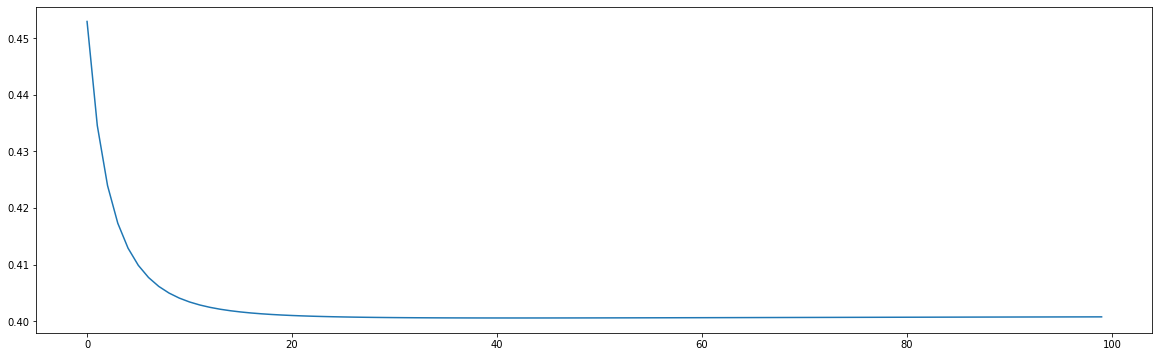

In [147]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 6)
plt.plot(costs)

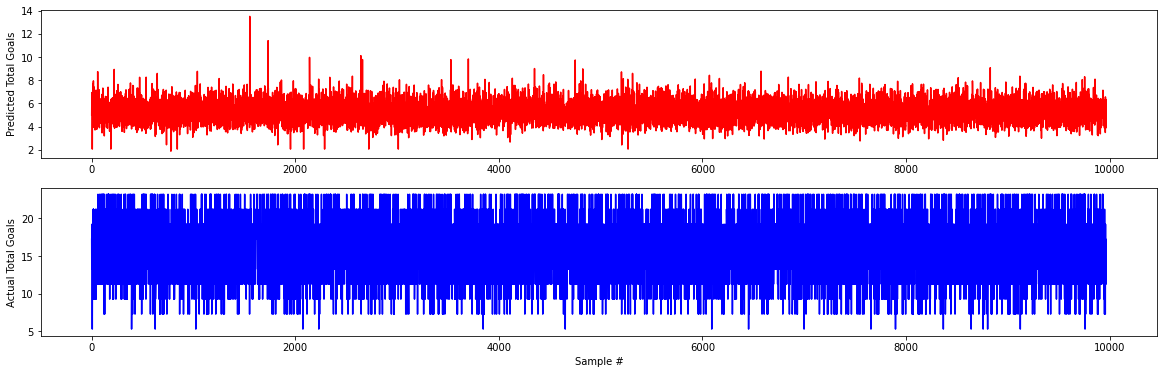

In [150]:
# denoarmalize predictions
train_predictions = np.dot(x_train, theta)
train_predictions = [(t_i * original_std["totalGoals"]) + original_mean["totalGoals"] for t_i in train_predictions]
t_train = [(ti * original_std["totalGoals"]) + original_mean["totalGoals"] for ti in t_train]

plt.plot(train_predictions, 'o')
plt.plot(t_train, 'g')


plt.subplot(211)
plt.plot(train_predictions, 'r-')
plt.ylabel('Predicted Total Goals')
plt.subplot(212)
plt.plot(t_train, 'b-')
plt.ylabel('Actual Total Goals')
plt.xlabel('Sample #')
plt.show()

array([[<AxesSubplot:title={'center':'Prediction Dist. (Train)'}>,
        <AxesSubplot:title={'center':'Target Dist. (Train)'}>]],
      dtype=object)

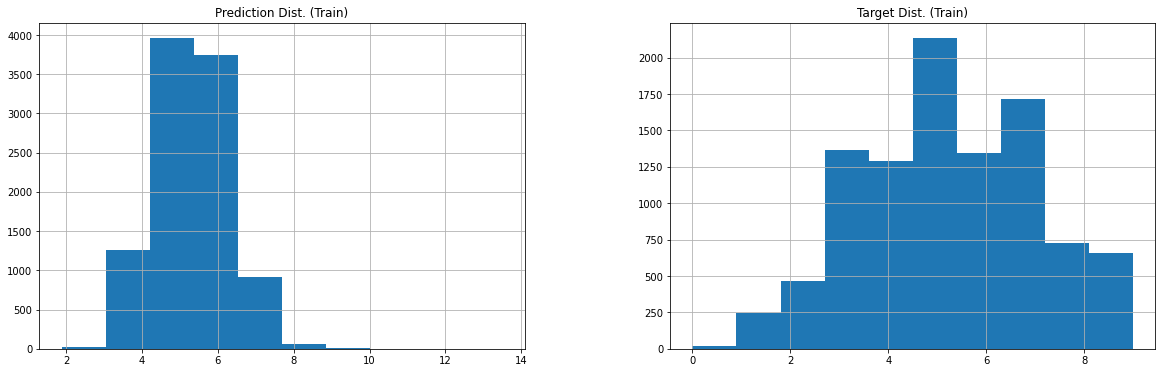

In [149]:
pred_and_targets_df = pd.DataFrame({'Prediction Dist. (Train)': train_predictions, 'Target Dist. (Train)': t_train})
pred_and_targets_df.hist()